# Exploring linear regions with tropical geometry

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

import numpy as np
import numpy.core.multiarray
from scipy.optimize import linprog
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, KFold

from tqdm.notebook import tqdm
import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
import scienceplots
from matplotlib.legend_handler import HandlerBase
from matplotlib.patches import Rectangle

from scipy.spatial import HalfspaceIntersection, ConvexHull
from scipy import stats

import networkx as nx
import itertools
import matplotlib.colors as mcolors
import warnings 

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import umap_

plt.style.use("science")

In [2]:
# # Prevent `ImportError: numpy.core.multiarray failed to import` for scipy.optimize.linprog
# !pip install numpy==1.26.4

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Neural network to approximate 3D function

### Define and plot 3D function

Functions $\phi_1$ through $\phi_4$ in the paper are defined here. Use a dict to also store TeX tiles and filenames.

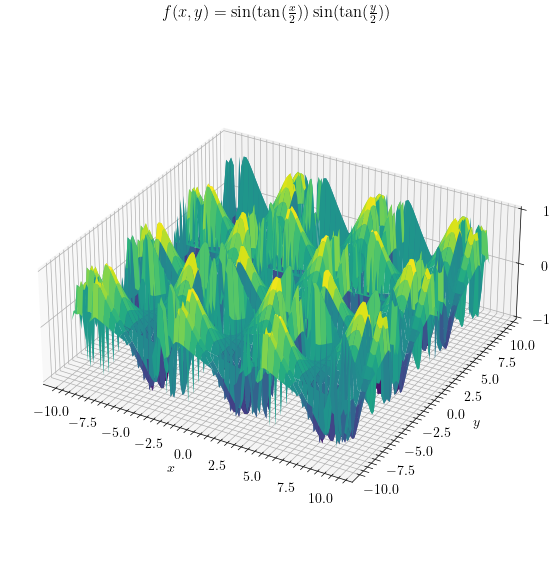

In [4]:
functions = [
    {"title": r"$f(x,y)=\sin(\log|x|+\log|y|)$",
    "filename": r"func0 sin(logx+logy)",
    "func": lambda x, y: np.sin((np.log(np.abs(x)) + np.log(np.abs(y))))},

    {"title": r"$f(x,y) = \frac{\sin(\sqrt{x^2 + y2})}{\sqrt{x2 + y^2}}$",
    "filename": r"func1 sin(sqrt(x2+y2)) div sqrt(x2+y2)",
    "func": lambda x, y: np.sin(np.sqrt(x**2+y**2))/np.sqrt(x**2+y**2)},
    
    {"title": r"$f(x,y) = \sin(\cos(\frac{x}{2}))\sin(\cos(\frac{y}{2}))$",
    "filename": r"func2 sin(cosx)sin(cosy)",
    "func": lambda x, y: np.sin(np.cos(x/2))*np.sin(np.cos(y/2))},
    
    {"title": r"$f(x,y) = \sin(\tan(\frac{x}{2}))\sin(\tan(\frac{y}{2}))$",
    "filename": r"func3 sin(tanx)sin(tany)",
    "func": lambda x, y: np.sin(np.tan(x/2))*np.sin(np.tan(y/2))},
]

def plot_function(function):
    """
    Create basic 3D plot of 
    """
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    x, y = np.meshgrid(x, y)
    z = function["func"](x, y)

    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(x, y, z, cmap="viridis")
    
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.0, 1.0, 0.5, 1]))
    
    ax.set_zticks([-1, 0, 1])
    
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_zlabel("$z$")
    ax.set_title(function["title"], pad=10)
    
    fig.subplots_adjust(top=0.85, bottom=0.15, left=0.05, right=0.95)
    plt.tight_layout()
    
    plt.show()

plot_function(functions[3])

### Define and train neural network

`Approximator` is our basic neural network class

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [500/10000], Loss: 0.0214
Epoch [1000/10000], Loss: 0.0092
Epoch [1500/10000], Loss: 0.0086
Epoch [2000/10000], Loss: 0.0084
Epoch [2500/10000], Loss: 0.0075
Epoch [3000/10000], Loss: 0.0033
Epoch [3500/10000], Loss: 0.0022
Epoch [4000/10000], Loss: 0.0021
Epoch [4500/10000], Loss: 0.0020
Epoch [5000/10000], Loss: 0.0020
Epoch [5500/10000], Loss: 0.0020
Epoch [6000/10000], Loss: 0.0019
Epoch [6500/10000], Loss: 0.0017
Epoch [7000/10000], Loss: 0.0016
Epoch [7500/10000], Loss: 0.0016
Epoch [8000/10000], Loss: 0.0016
Epoch [8500/10000], Loss: 0.0016
Epoch [9000/10000], Loss: 0.0016
Epoch [9500/10000], Loss: 0.0016
Epoch [10000/10000], Loss: 0.0016


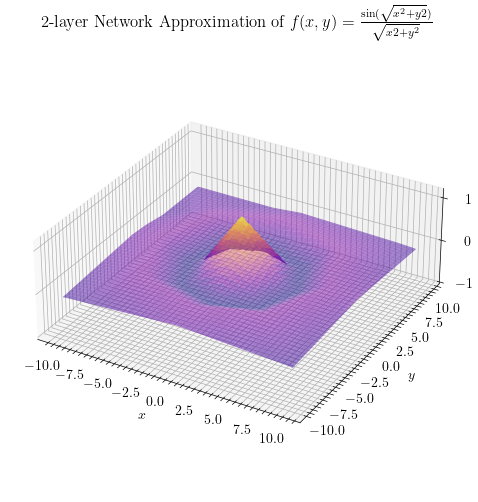

In [5]:
class Approximator(nn.Module):
    """
    Basic neural network to approximate a 3D function
    """
    def __init__(self, input_size, hidden_size, output_size, num_layers, skip_connections=None):
        """
        If specified, `skip_connections` should be a list (or other iterable) where each entry is a tuple/iterable containing 2 ints.
        Entering e.g. `[(0,3), (4,6)]` 
        means that the output of hidden layer 0 (first hidden layer) feeds into the input of hidden layer 3, and output of 4 feeds into input of 6.
        """
        super(Approximator, self).__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.ReLU()] 
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.skip_connections = skip_connections
        if skip_connections is None:
            self.forward = self._forward_noskip
        else:
            self.forward = self._forward_skip

    def _forward_noskip(self, x):
        """
        Simple `forward` method to be used when no skip connections are provided.
        """
        return self.model(x)

    def _forward_skip(self, x):
        """
        `forward` method supporting skip connections.
        Would be more readable if re-written so that Linear and ReLU layers are paired, but the rest of the code was written before this
        """
        previous_layers = []
        out = x
        layer_counter = 0
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                for (skip_from, skip_to) in self.skip_connections:
                    if layer_counter == skip_to:
                        out = out + previous_layers[skip_from]
                out = layer(out)
                layer_counter += 1
            elif isinstance(layer, nn.ReLU): # After ReLU activation, append to layer list
                out = layer(out)
                previous_layers.append(out) # Post-activation
        return out

def train_model(model, function, num_epochs=1000, learning_rate=1e-3, plot=False):
    """
    Basic training loop with Adam optimizer. If plot=True, displays a plot of fitted function.
    """

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Generate training data and convert to PyTorch tensors
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    x, y = np.meshgrid(x, y)
    z = function["func"](x, y)
    inputs = torch.tensor(np.vstack((x.flatten(), y.flatten())).T, dtype=torch.float32).to(device)
    targets = torch.tensor(z.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    
    # Main training loop
    for epoch in tqdm(range(num_epochs)):
        model.train()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 500 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    if plot:
        model.eval()
        with torch.no_grad():
            # Not really an actual test set, just used for plotting
            test_inputs = torch.tensor(np.vstack((x.flatten(), y.flatten())).T, dtype=torch.float32).to(device)
            test_outputs = model(test_inputs)
            test_outputs = test_outputs.cpu().numpy().reshape(x.shape)
        fig = plt.figure(figsize=(20, 6))
        ax = fig.add_subplot(111, projection="3d")
        # ax.plot_surface(x, y, z, cmap="viridis", alpha=0.5, label="Original")
        ax.plot_surface(x, y, test_outputs, cmap="plasma", alpha=0.5, label="Predicted")
        
        ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.0, 1.0, 0.5, 1]))
        ax.set_zticks([-1, 0, 1])
        ax.set_title(f"{num_layers}-layer Network Approximation of {function['title']}")
        ax.set_xlabel("$x$")
        ax.set_ylabel("$y$")
        ax.set_zlabel("$z$")
        
        plt.show()

# Model initialization
input_size = 2
hidden_size = 5
output_size = 1
num_layers = 2
skip_connections = None#[(0,2)]
model = Approximator(input_size, hidden_size, output_size, num_layers, skip_connections).to(device)

train_model(model, functions[1], num_epochs=10_000, plot=True)

### Find hyperplanes defined by ReLU activations in network

In [6]:
def get_dimensions(model):
    """
    Helper function for `get_truth_assignments`.
    Returns list of integers. Each entry corresponds to the size of each layer in `model` that has ReLU activation.
    """
    dims_list = []
    layers = list(model.children())
    if isinstance(layers[0], nn.Sequential): # When all layers are contained within a single nn.Sequential, we first need to unpack it
        layers = layers[0]
    for i in range(len(layers)-1):
        # Find layers that have ReLU activation
        if isinstance(layers[i], nn.Linear) and isinstance(layers[i + 1], nn.ReLU):
            dims_list.append(layers[i].weight.size(0))
    return dims_list

def get_feasible_point(hyperplanes, tol=1e-12):
    """
    Finds feasible region for linear program A_ub * x <= b_ub, 
    where A_ub is constructed from vector parts of hyperplanes, and b_ub is constructed from scalar parts
    """
    A_ub = np.array([plane[0] for plane in hyperplanes])
    b_ub = np.array([plane[1] for plane in hyperplanes])
    b_ub = np.array(b_ub) - tol # Enforce strict inequality (to prevent regions from having 0 area)
    
    c = np.zeros(A_ub.shape[1]) # Objective function (minimize zeros, which means just checking feasibility)
    
    result = linprog(c, A_ub=A_ub, b_ub=b_ub, method="highs", bounds=(None,None))
    return result

def get_truth_assignments(model):
    """
    Returns list where the i-th entry is a list of all possible truth assignments of 0/1 to neurons in the i-th layer
    """
    dims_list = get_dimensions(model)
    num_neurons = np.sum(dims_list)
    num_assignments = 2**num_neurons

    assignments = []
    for dim in dims_list:
        ta = [] # Truth assignment
        for i in range(2**dim):
            bin_i = str(bin(i)[2:]).zfill(dim) # Binary representation of i (padded with zeros)
            bin_i = np.asarray(list(bin_i), dtype=int)
            ta.append(bin_i)
        assignments.append(ta)
    return assignments

def matrix_to_nonnegative(A):
    """
    Helper function for get_linear_region.
    Given matrix `A`, returns two matrices `A_pos` and `A_neg` s.t. A=A_pos-A_neg and all entries in A_pos and A_neg are non-negative.
    """
    A_pos = A.copy()
    A_pos[A<0] = 0
    
    A_neg = -1 * A.copy()
    A_neg[A>0] = 0
    return A_pos, A_neg

def get_linear_region(model, ta):
    """
    Given a truth assignment `ta`, which maps each neuron to 0 or 1, find the set of hyperplanes that defines the linear region.
    A neuron mapping to 0 means that we choose the negative half of the ReLU activation, and 1 means positive half.
    """
    # Initial bounding box: (-10,10) x (-10,10)
    hyperplanes = [(np.array([1,0]),10),
                   (np.array([-1,0]),10),
                   (np.array([0,1]),10),
                   (np.array([0,-1]),10),]

    # Initialize F^(0), H^(0), G^(0), and their respective vectors
    F = np.eye(model.model[0].in_features)
    H, G = matrix_to_nonnegative(F) # H^(0) is identity, G^(0) is zero matrix.
    F_vec = np.zeros(F.shape[0])
    G_vec = np.zeros(F.shape[0])
    H_vec = np.zeros(F.shape[0])
    previous = [] # Storage of values of G and H to use in skip connections (H not needed)
    layer_index = 0
    for i in range(len(model.model)-1):
        layer = model.model[i]
        if isinstance(layer, nn.Linear) and isinstance(model.model[i+1], nn.ReLU): # If layer has ReLU activation
            A = layer.weight.detach().numpy()
            b = layer.bias.detach().numpy()
            A_pos, A_neg = matrix_to_nonnegative(A)

            # Recurrence relations
            G_next = A_pos @ G + A_neg @ F
            H_next = A_pos @ F + A_neg @ G
            G_vec_next = A_pos @ G_vec + A_neg @ F_vec
            H_vec_next = A_pos @ F_vec + A_neg @ G_vec + b

            # Account for skip connections
            # This part of the recurrence relation only affects G and H, but must be before activation has been applied (i.e. F_next not yet calculated)
            if model.skip_connections is not None:
                skips_in = [j for (j,k) in model.skip_connections if k==layer_index]
                for j in skips_in:
                    F_prev, G_prev, F_vec_prev, G_vec_prev, = previous[j]
                    G_next += A_neg @ (F_prev - G_prev)
                    H_next += A_pos @ (F_prev - G_prev)
                    G_vec_next += A_neg @ (F_vec_prev - G_vec_prev)
                    H_vec_next += A_pos @ (F_vec_prev - G_vec_prev)

            # Take the truth assignment as one column. Repeat this col horizontally so that every row contains entirely 0 or entirely 1.
            repeated_ta = np.repeat(ta[layer_index], F.shape[1]).reshape(len(ta[layer_index]), F.shape[1])
            
            # If we were just computing the output normally, this would just be `F_next = max(H_next, G_next)`
            # For cols where we assign 0 to a neuron, we choose left side of max() function (H_next), and choose G_next otherwise.
            F_next = np.where(repeated_ta == 1, H_next, G_next)
            F_vec_next = np.where(ta[layer_index] == 1, H_vec_next, G_vec_next)

            # A hyperplane is introduced at each row of the solution of H^(l+1)(x) = G^(l+1)(x).
            # For each row, use the truth assignment to pick which half of the hyperplane we want
            hyp_A = H_next - G_next
            hyp_b = G_vec_next - H_vec_next
            for j in range(hyp_A.shape[0]):
                if ta[layer_index][j] == 0: 
                    # Truth assignment chooses the half of hyperplane given by G, so we have H < G. 
                    # Resulting linear program is A_ub*x <= b_ub, where A_ub=(H-G) and b_ub=(G_vec-H_vec)
                    hyperplanes.append((hyp_A[j], hyp_b[j]))
                else: 
                    # Resulting linear program has A_ub=(G-H) and b_ub=(H_vec-G_vec), so multiply by -1
                    hyperplanes.append((-hyp_A[j], -hyp_b[j]))

            # Before next iteration, update values
            F = F_next
            G = G_next
            H = H_next
            F_vec = F_vec_next
            G_vec = G_vec_next
            H_vec = H_vec_next

            if model.skip_connections is not None:
                previous.append((F,G,F_vec,G_vec)) # Store for future skip connections
            layer_index += 1

            if not get_feasible_point(hyperplanes).success:
                # If region is infeasible now, it will still be infeasible with more iterations
                # Return the index of the layer where this truth assignment became infeasible so dfs can rule it out
                return layer_index
                
    return hyperplanes

def dfs(model, truth_assignments, current_assignments, depth, results, pbar):
    """
    Recursive backend of `get_all_linear_regions`.
    Performs recursive depth-first search of all truth assignments.
        `truth_assignments` - assignments generated by `get_truth_assignments`
        `depth` - current depth
        `results` - passed by reference. Results are not returned
        `pbar` - tqdm progress bar
    """
    if depth == len(truth_assignments):
        result = get_linear_region(model, current_assignments)
        if isinstance(result, int): # Infeasible region - returns index of failure
            return result # fail_index
        else:
            if pbar is not None:
                pbar.update(1)
            results.append(result)
            return

    for layer_assignment in truth_assignments[depth]:
        fail_index = dfs(model, truth_assignments, current_assignments+[layer_assignment], depth + 1, results, pbar)
        if fail_index is not None:
            if depth >= fail_index:
                return fail_index
            else:
                if pbar is not None:
                    num_skipped = np.prod([len(l) for l in truth_assignments[depth+1:]]) # product of num neurons in deeper layers
                    pbar.update(int(num_skipped))

def get_all_linear_regions(model, use_tqdm=True):
    """
    Performs depth-first search over all possible truth assignments 0/1 to each neuron.
    Whenever a region is found to be infeasible, dfs abandons the branch corresponding to it
    """
    model = model.to("cpu") # Prevent repeated copying back and forth
    truth_assignments = get_truth_assignments(model)
    num_neurons = np.sum(get_dimensions(model))
    total_combinations = 2 ** np.sum(get_dimensions(model))
    results = []
    if use_tqdm:
        with tqdm(total=total_combinations, desc="Finding linear regions", colour="orange", mininterval=0.5, smoothing=0) as pbar:
            dfs(model, truth_assignments, [], 0, results, pbar) # `results` is filled after being passed by reference
    else:
        dfs(model, truth_assignments, [], 0, results, None)
    model = model.to(device)
    return results
    
linear_regions = get_all_linear_regions(model)

Finding linear regions:   0%|          | 0/1024 [00:00<?, ?it/s]

### Plot linear regions

Number of regions: 48


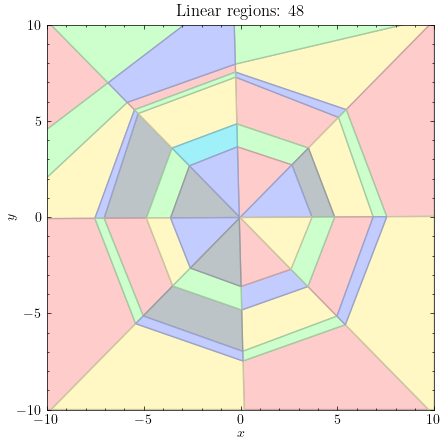

In [7]:
def get_region_intersection(hyperplanes):
    """
    Given a set of half-planes, construct scipy.spatial.HalfspaceIntersection object representing their intersections
    """
    # Use HalfspaceIntersection to find vertices of linear region
    feasible_point = get_feasible_point(hyperplanes)
    if not feasible_point.success:
        raise ValueError("No feasible point found")
    feasible_point = feasible_point.x
    
    # Convert (a, b) pairs to the format required by HalfspaceIntersection.
    # Currently, pairs are in form Ax < b. HalfspaceIntersection expects Ax+b<0
    halfspaces = []
    for plane in hyperplanes:
        a, b = plane[:2]
        halfspaces.append(np.append(a, -b))  # ax + b < 0 -> [a, -b]

    hs = HalfspaceIntersection(np.array(halfspaces), feasible_point)
    
    return hs

def sort_vertices(vertices):
    """
    Sort clockwise so that resulting region is plotted as convex hull of given vertices.
    """
    centroid = np.mean(vertices, axis=0)
    sorted_vertices = sorted(vertices, key=lambda v: np.arctan2(v[1] - centroid[1], v[0] - centroid[0]))
    return sorted_vertices

def darken_color(color, amount=0.5):
    """
    Helper function for `plot_regions`. Darken a given color by a specified amount.
    """
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = mcolors.ColorConverter.to_rgb(c)
    c = [max(0, min(1, x * amount)) for x in c]
    return c
    
def plot_regions(regions, save_dir=None, save_dir2=None, show=True):
    """
    Using the linear regions found by `get_all_linear_regions`, color and plot regions with matplotlib.
    If save_dir is specified, also saves resulting figure in given directory. Can also specify second dir, save_dir2, for two formats.
    """
    fig, ax = plt.subplots(figsize=(5,5))
    region_vertices = []
    colors = ["#ffcccc", "#c2ccff", "#ccffcc", "#fff8c5", "#bcc4c8", "#9ff0f9", "#aceff7"] # red, blue, green, yellow, gray, teal, purple
    edge_colors = [darken_color(c, 0.8) for c in colors]
    for hyperplanes in regions:
        hs = get_region_intersection(hyperplanes)
        vertices = hs.intersections
        vertices = sort_vertices(vertices)
        region_vertices.append(vertices)
    
    # Graph coloring
    G = nx.Graph()
    for i, v1 in enumerate(region_vertices):
        for j, v2 in enumerate(region_vertices):
            if i < j:
                if any(np.allclose(a, b) for a, b in itertools.product(v1, v2)): # Adjacent regions share vertices
                    G.add_edge(i, j)
    coloring = nx.coloring.greedy_color(G, strategy="largest_first")
    if max(coloring.values())+1 > len(colors):
        warnings.warn(f"Graph coloring uses {max(coloring.values())+1} colors, but only {len(colors)} colors are defined. Some neighboring regions have same color.")
    for i, v in enumerate(region_vertices):
        color = colors[coloring[i] % len(colors)]
        edge_color = edge_colors[coloring[i] % len(colors)]
        ax.fill(*zip(*v), color=color, edgecolor=edge_color)
    
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.set_xticks([-10,-5,0,5,10])
    ax.set_yticks([-10,-5,0,5,10])
    ax.set_xlabel("$x$", labelpad=0)
    ax.set_ylabel("$y$", labelpad=0)
    ax.set_title(f"Linear regions: {len(regions)}")

    if save_dir is not None:
        fig.savefig(save_dir)
    if save_dir2 is not None:
        fig.savefig(save_dir2)
    if show:
        plt.show()
    
print(f"Number of regions: {len(linear_regions)}")
plot_regions(linear_regions)#, save_dir="images/test.svg")

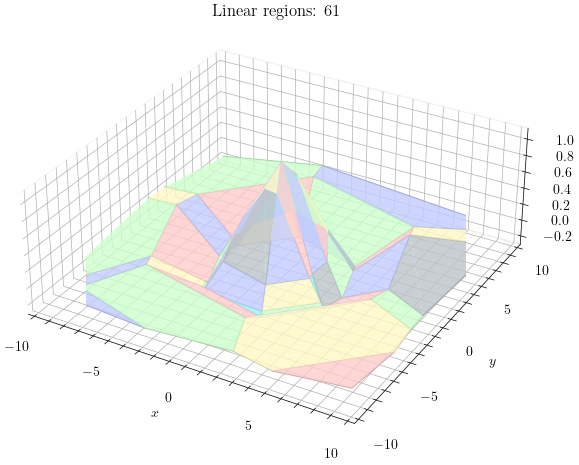

In [149]:

def plot_regions_3d(regions, save_dir=None, save_dir2=None, show=True):
    """
    Using the linear regions found by `get_all_linear_regions`, color and plot regions with matplotlib.
    If save_dir is specified, also saves resulting figure in given directory. Can also specify second dir, save_dir2, for two formats.
    """
    fig = plt.figure(figsize=(8, 4), constrained_layout=True)
    ax = fig.add_subplot(111, projection="3d")
    # ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.0, 1.0, 0.5, 1]))
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.5, 1.5, 0.75, 1]))
    
    region_vertices = []
    colors = ["#ffcccc", "#c2ccff", "#ccffcc", "#fff8c5", "#bcc4c8", "#9ff0f9", "#aceff7"] # red, blue, green, yellow, gray, teal, purple
    edge_colors = [darken_color(c, 0.8) for c in colors]
    for hyperplanes in regions:
        hs = get_region_intersection(hyperplanes)
        vertices = hs.intersections
        vertices = sort_vertices(vertices)
        region_vertices.append(vertices)
    
    # Graph coloring
    G = nx.Graph()
    for i, v1 in enumerate(region_vertices):
        for j, v2 in enumerate(region_vertices):
            if i < j:
                if any(np.allclose(a, b) for a, b in itertools.product(v1, v2)): # Adjacent regions share vertices
                    G.add_edge(i, j)
    coloring = nx.coloring.greedy_color(G, strategy="largest_first")
    if max(coloring.values())+1 > len(colors):
        warnings.warn(f"Graph coloring uses {max(coloring.values())+1} colors, but only {len(colors)} colors are defined. Some neighboring regions have same color.")
    for i, v in enumerate(region_vertices):
        color = colors[coloring[i] % len(colors)]
        edge_color = edge_colors[coloring[i] % len(colors)]
        # ax.fill(*zip(*v), color=color, edgecolor=edge_color)
        with torch.no_grad():
            z = [model(torch.Tensor(coord).to(device)).cpu().numpy()[0] for coord in v]
            z = np.asarray(z)
        ax.plot_trisurf(*zip(*v), z, color=color,shade=False, alpha=0.8)
        ax.plot(*zip(*v), z, color=edge_color)
    
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.set_xlabel("$x$", labelpad=0)
    ax.set_ylabel("$y$", labelpad=0)
    ax.set_zlabel("$z$", labelpad=0)
    ax.set_xticks([-10,-5,0,5,10])
    ax.set_yticks([-10,-5,0,5,10])
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_title(f"Linear regions: {len(regions)}")
    fig.tight_layout(pad=0)

    if save_dir is not None:
        fig.savefig(save_dir, bbox_inches='tight')
    if save_dir2 is not None:
        fig.savefig(save_dir2, bbox_inches='tight')
    if show:
        plt.show()


plot_regions_3d(linear_regions)#, save_dir="images/test.svg")

## Experiments

### For various parameter combinations, find number of linear regions upon random initialization

In [58]:
# Random initialization - number of linear regions with/without skip connections
# With skip: 93.104 (500 samples)
# Without skip: 57.754 (500 samples)

parameter_combinations = [(4,4)]
skip_connections = [(0,2), (1,3)]

# results_skip = []
# results_noskip = []
for trial in tqdm(range(10)):
    # Model initialization
    input_size = 2
    output_size = 1
    model = Approximator(input_size, hidden_size, output_size, num_layers, skip_connections)#.to(device)
    linear_regions = get_all_linear_regions(model, use_tqdm=False)
    if skip_connections is not None:
        results_skip.append(len(linear_regions))
    else:
        results_noskip.append(len(linear_regions))
print(np.mean(results_skip))
print(np.mean(results_noskip))

  0%|          | 0/10 [00:00<?, ?it/s]

28.84375
29.92


In [93]:
# Repeatability
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

parameter_combinations = [
                          (6, 5, [(0,2), (1,3), (2,4)]),
                          (6, 4, [(0,2), (1,3), (2,4)]),
                          (5, 4, [(0,2), (1,4)]),
                          (4, 4, [(0,2), (1,3)]),
                          (3, 6, [(0,2)]),
                          (3, 4, [(0,2)]),
                         ]
# Primary sort: total neurons. Secondary sort: number of layers.
# Ensures that most computationally expensive parameter combinations are performed first
parameter_combinations = sorted(parameter_combinations, key = lambda x: (-x[0]*x[1], -x[0])) 

results = []
for num_layers, hidden_size, skip_connections in parameter_combinations:
    results_skip = []
    results_noskip = []
    for trial in tqdm(range(50), desc=f"{num_layers} layers, {hidden_size} neurons"):
        # Model initialization
        input_size = 2
        output_size = 1
        model_skip = Approximator(input_size, hidden_size, output_size, num_layers, skip_connections=skip_connections)
        results_skip.append(len(get_all_linear_regions(model_skip, use_tqdm=False)))
        model_noskip = Approximator(input_size, hidden_size, output_size, num_layers, skip_connections=None)
        results_noskip.append(len(get_all_linear_regions(model_noskip, use_tqdm=False)))
        
    # Statistical tests

    # Goodness-of-fit for gamma distribution
    params_skip = stats.gamma.fit(results_skip)
    ks_stat_skip, ks_p_skip = stats.kstest(results_skip, "gamma", args=params_skip)
    params_noskip = stats.gamma.fit(results_noskip)
    ks_stat_noskip, ks_p_noskip = stats.kstest(results_noskip, "gamma", args=params_noskip)

    # Difference of means
    u_stat, p_value = stats.mannwhitneyu(results_skip, results_noskip, alternative="two-sided")
    reject_null = p_value < 0.05
    # print(f"Mann-Whitney U result: U-statistic = {u_stat:.4f}, p-value = {p_value:.4f}")
    results.append([(num_layers,hidden_size), skip_connections, ks_stat_skip, ks_p_skip, ks_stat_noskip, ks_p_noskip, 
                    np.mean(results_skip), np.mean(results_noskip), u_stat, p_value, reject_null])

results_df = pd.DataFrame(results, columns=["Model params", "Skip connections", "KS stat (skip)", "KS p-value (skip)", "KS stat (no skip)", "KS p-value (no skip)", "Sample mean (skip)", "Sample mean (no skip)", "U-statistic", "p-value", "Reject null"])
display(results_df)

6 layers, 5 neurons:   0%|          | 0/50 [00:00<?, ?it/s]

6 layers, 4 neurons:   0%|          | 0/50 [00:00<?, ?it/s]

5 layers, 4 neurons:   0%|          | 0/50 [00:00<?, ?it/s]

3 layers, 6 neurons:   0%|          | 0/50 [00:00<?, ?it/s]

4 layers, 4 neurons:   0%|          | 0/50 [00:00<?, ?it/s]

3 layers, 4 neurons:   0%|          | 0/50 [00:00<?, ?it/s]

,Model params,Skip connections,KS stat (skip),KS p-value (skip),KS stat (no skip),KS p-value (no skip),Sample mean (skip),Sample mean (no skip),U-statistic,p-value,Reject null
0,"(6, 5)","[(0, 2), (1, 3), (2, 4)]",0.068662,0.959586,0.085247,0.830409,206.78,117.68,2237.5,1.012238e-11,True
1,"(6, 4)","[(0, 2), (1, 3), (2, 4)]",0.074499,0.924753,0.093665,0.737382,111.62,62.18,2161.5,3.358209e-10,True
2,"(5, 4)","[(0, 2), (1, 4)]",0.088030,0.800985,0.096088,0.708931,96.72,53.28,2242.0,8.114300e-12,True
3,"(3, 6)","[(0, 2)]",0.086677,0.815485,0.099773,0.665034,137.64,115.66,1711.5,1.480299e-03,True
4,"(4, 4)","[(0, 2), (1, 3)]",0.083360,0.849386,0.062121,0.983981,71.54,53.52,1804.5,1.332896e-04,True
5,"(3, 4)","[(0, 2)]",0.087208,0.809840,0.058173,0.992202,52.32,42.36,1728.0,9.902878e-04,True


In [99]:
# Version with training

def train_model_no_print(model, function, num_epochs=1000, learning_rate=1e-3):
    """
    Basic training loop with Adam optimizer. If plot=True, displays a plot of fitted function.
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    x, y = np.meshgrid(x, y)
    z = function["func"](x, y)
    inputs = torch.tensor(np.vstack((x.flatten(), y.flatten())).T, dtype=torch.float32).to(device)
    targets = torch.tensor(z.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    model.train()
    for epoch in range(num_epochs):
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Repeatability
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

parameter_combinations = [
                          (6, 5, [(0,2), (1,3), (2,4)]),
                          (6, 4, [(0,2), (1,3), (2,4)]),
                          (5, 4, [(0,2), (1,4)]),
                          (4, 4, [(0,2), (1,3)]),
                          (3, 6, [(0,2)]),
                          (3, 4, [(0,2)]),
                         ]
# Primary sort: total neurons. Secondary sort: number of layers.
# Ensures that most computationally expensive parameter combinations are performed first
parameter_combinations = sorted(parameter_combinations, key = lambda x: (-x[0]*x[1], -x[0])) 

results = []
for num_layers, hidden_size, skip_connections in parameter_combinations:
    results_skip = []
    results_noskip = []
    for trial in tqdm(range(50), desc=f"{num_layers} layers, {hidden_size} neurons"):
        # Model initialization
        input_size = 2
        output_size = 1
        model_skip = Approximator(input_size, hidden_size, output_size, num_layers, skip_connections=skip_connections).to(device)
        train_model_no_print(model_skip, functions[0], num_epochs=5_000)
        model_skip.to("cpu")
        results_skip.append(len(get_all_linear_regions(model_skip, use_tqdm=False)))
        model_noskip = Approximator(input_size, hidden_size, output_size, num_layers, skip_connections=None).to(device)
        train_model_no_print(model_noskip, functions[0], num_epochs=5_000)
        model_noskip.to("cpu")
        results_noskip.append(len(get_all_linear_regions(model_noskip, use_tqdm=False)))
        
    # Statistical tests

    # Goodness-of-fit for gamma distribution
    params_skip = stats.gamma.fit(results_skip)
    ks_stat_skip, ks_p_skip = stats.kstest(results_skip, "gamma", args=params_skip)
    params_noskip = stats.gamma.fit(results_noskip)
    ks_stat_noskip, ks_p_noskip = stats.kstest(results_noskip, "gamma", args=params_noskip)

    # Difference of means
    u_stat, p_value = stats.mannwhitneyu(results_skip, results_noskip, alternative="two-sided")
    reject_null = p_value < 0.05
    # print(f"Mann-Whitney U result: U-statistic = {u_stat:.4f}, p-value = {p_value:.4f}")
    results.append([(num_layers,hidden_size), skip_connections, ks_stat_skip, ks_p_skip, ks_stat_noskip, ks_p_noskip, 
                    np.mean(results_skip), np.mean(results_noskip), u_stat, p_value, reject_null])
    
    results_df = pd.DataFrame(results, columns=["Model params", "Skip connections", "KS stat (skip)", "KS p-value (skip)", "KS stat (no skip)", "KS p-value (no skip)", "Sample mean (skip)", "Sample mean (no skip)", "U-statistic", "p-value", "Reject null"])
    display(results_df)

,Model params,Skip connections,KS stat (skip),KS p-value (skip),KS stat (no skip),KS p-value (no skip),Sample mean (skip),Sample mean (no skip),U-statistic,p-value,Reject null
0,"(6, 5)","[(0, 2), (1, 3), (2, 4)]",0.078383,0.894786,0.057696,0.992925,518.32,447.46,1616.0,0.011743,True
1,"(6, 4)","[(0, 2), (1, 3), (2, 4)]",0.078317,0.895337,0.086691,0.815335,235.76,186.20,1571.5,0.026897,True
2,"(5, 4)","[(0, 2), (1, 4)]",0.106337,0.586729,0.071445,0.944548,199.14,136.24,1827.5,0.000070,True
3,"(3, 6)","[(0, 2)]",0.066003,0.971297,0.071567,0.943822,181.64,199.20,1013.5,0.103722,False
4,"(4, 4)","[(0, 2), (1, 3)]",0.078445,0.894270,0.067608,0.964532,109.54,121.70,1077.0,0.234301,False
5,"(3, 4)","[(0, 2)]",0.062867,0.981926,0.097280,0.694792,68.18,64.04,1473.0,0.124948,False


In [100]:
# Expanded sample size for (4,4)

# Repeatability
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

parameter_combinations = [
                          (4, 4, [(0,2), (1,3)]),
                         ]
# Primary sort: total neurons. Secondary sort: number of layers.
# Ensures that most computationally expensive parameter combinations are performed first
parameter_combinations = sorted(parameter_combinations, key = lambda x: (-x[0]*x[1], -x[0])) 

results = []
for num_layers, hidden_size, skip_connections in parameter_combinations:
    results_skip = []
    results_noskip = []
    for trial in tqdm(range(1000), desc=f"{num_layers} layers, {hidden_size} neurons"):
        # Model initialization
        input_size = 2
        output_size = 1
        model_skip = Approximator(input_size, hidden_size, output_size, num_layers, skip_connections=skip_connections)
        results_skip.append(len(get_all_linear_regions(model_skip, use_tqdm=False)))
        model_noskip = Approximator(input_size, hidden_size, output_size, num_layers, skip_connections=None)
        results_noskip.append(len(get_all_linear_regions(model_noskip, use_tqdm=False)))
        
    # Statistical tests

    # Goodness-of-fit for gamma distribution
    params_skip = stats.gamma.fit(results_skip)
    ks_stat_skip, ks_p_skip = stats.kstest(results_skip, "gamma", args=params_skip)
    params_noskip = stats.gamma.fit(results_noskip)
    ks_stat_noskip, ks_p_noskip = stats.kstest(results_noskip, "gamma", args=params_noskip)

    # Difference of means
    u_stat, p_value = stats.mannwhitneyu(results_skip, results_noskip, alternative="two-sided")
    reject_null = p_value < 0.05
    # print(f"Mann-Whitney U result: U-statistic = {u_stat:.4f}, p-value = {p_value:.4f}")
    results.append([(num_layers,hidden_size), skip_connections, ks_stat_skip, ks_p_skip, ks_stat_noskip, ks_p_noskip, 
                    np.mean(results_skip), np.mean(results_noskip), u_stat, p_value, reject_null])

results_df = pd.DataFrame(results, columns=["Model params", "Skip connections", "KS stat (skip)", "KS p-value (skip)", "KS stat (no skip)", "KS p-value (no skip)", "Sample mean (skip)", "Sample mean (no skip)", "U-statistic", "p-value", "Reject null"])
display(results_df)

4 layers, 4 neurons:   0%|          | 0/1000 [00:00<?, ?it/s]

,Model params,Skip connections,KS stat (skip),KS p-value (skip),KS stat (no skip),KS p-value (no skip),Sample mean (skip),Sample mean (no skip),U-statistic,p-value,Reject null
0,"(4, 4)","[(0, 2), (1, 3)]",0.018373,0.882068,0.025098,0.545952,76.502,53.084,771668.0,2.827382e-98,True


In [146]:
fig, ax = plt.subplots(figsize=(10,4))
hist_counts_noskip, bin_edges_noskip, _ = ax.hist(results_noskip, color="blue", label="Without skip connections", alpha=0.2, bins=20)
hist_counts_skip,   bin_edges_skip,   _ = ax.hist(results_skip, color="red", label="With skip connections", alpha=0.2, bins=20)
ax.set_title("Number of Linear Regions of 1000 Randomly-Initialized Neural Networks")
ax.set_xlabel("Number of Linear Regions")
ax.set_ylabel("Frequency")
ax.axvline(np.mean(results_noskip), color="blue", linestyle="dashed", linewidth=2, alpha=0.5)
ax.axvline(np.mean(results_skip), color="red", linestyle="dashed", linewidth=2, alpha=0.5)
ax.text(np.mean(results_skip)+3, 125, f"Sample mean \nwith skips: {np.mean(results_skip):.1f}", c="red")
ax.text(np.mean(results_noskip)-3, 125, f"Sample mean \nwithout skips: {np.mean(results_noskip):.1f}", c="blue", horizontalalignment="right")


params_skip = stats.gamma.fit(results_skip)
params_noskip = stats.gamma.fit(results_noskip)
ks_stat_skip, p_value_skip = stats.kstest(results_skip, "gamma", args=params_skip)
ks_stat_noskip, p_value_noskip = stats.kstest(results_noskip, "gamma", args=params_noskip)
bin_width_skip = bin_edges_skip[1] - bin_edges_skip[0]
bin_width_noskip = bin_edges_noskip[1] - bin_edges_noskip[0]
scaling_factor_skip = sum(hist_counts_skip) * bin_width_skip 
scaling_factor_noskip = sum(hist_counts_noskip) * bin_width_noskip 


x = np.linspace(min(results_skip), max(results_skip), 1000)
pdf = stats.gamma.pdf(x, *params_skip) * scaling_factor_skip
ax.plot(x, pdf, c="red")
ax.text(130, 20, f"$\Gamma(k={params_skip[0]:.1f},\\theta={params_skip[1]:.1f})+{params_skip[2]:.1f}$", c="red")


x = np.linspace(min(results_noskip), max(results_noskip), 1000)
pdf = stats.gamma.pdf(x, *params_noskip) * scaling_factor_noskip
ax.plot(x, pdf, c="blue")
ax.text(95, 12, f"$\Gamma(k={params_noskip[0]:.1f},\\theta={params_noskip[1]:.1f})+{params_noskip[2]:.1f}$", c="blue")

ax.legend()
fig.savefig(f"random_init_linear_regions_with_dist.pdf")

plt.show()

C:\Users\Johnn\AppData\Local\Temp\ipykernel_16040\4219660142.py:37: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


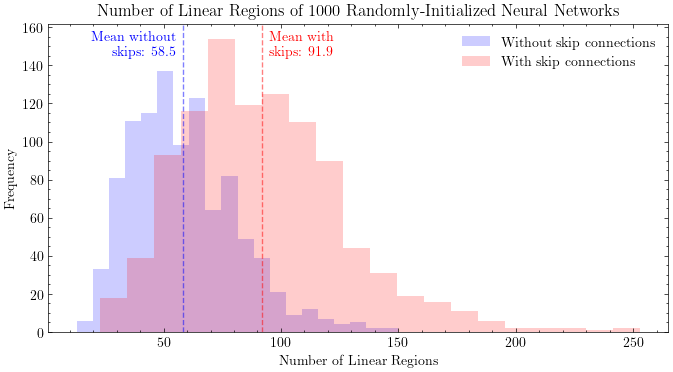

In [248]:
fig, ax = plt.subplots(figsize=(8,4))
hist_counts_noskip, bin_edges_noskip, _ = ax.hist(results_noskip, color="blue", label="Without skip connections", alpha=0.2, bins=20)
hist_counts_skip,   bin_edges_skip,   _ = ax.hist(results_skip, color="red", label="With skip connections", alpha=0.2, bins=20)
ax.set_title("Number of Linear Regions of 1000 Randomly-Initialized Neural Networks")
ax.set_xlabel("Number of Linear Regions")
ax.set_ylabel("Frequency")
ax.axvline(np.mean(results_noskip), color="blue", linestyle="dashed", linewidth=1, alpha=0.5)
ax.axvline(np.mean(results_skip), color="red", linestyle="dashed", linewidth=1, alpha=0.5)
ax.text(np.mean(results_skip)+3, 145, f"Sample mean \nwith skips: {np.mean(results_skip):.1f}", c="red")
ax.text(np.mean(results_noskip)-3, 145, f"Sample mean \nwithout skips: {np.mean(results_noskip):.1f}", c="blue", horizontalalignment="right")


params_skip = stats.gamma.fit(results_skip)
params_noskip = stats.gamma.fit(results_noskip)
ks_stat_skip, p_value_skip = stats.kstest(results_skip, "gamma", args=params_skip)
ks_stat_noskip, p_value_noskip = stats.kstest(results_noskip, "gamma", args=params_noskip)
bin_width_skip = bin_edges_skip[1] - bin_edges_skip[0]
bin_width_noskip = bin_edges_noskip[1] - bin_edges_noskip[0]
scaling_factor_skip = sum(hist_counts_skip) * bin_width_skip 
scaling_factor_noskip = sum(hist_counts_noskip) * bin_width_noskip 


x = np.linspace(min(results_skip), max(results_skip), 1000)
pdf = stats.gamma.pdf(x, *params_skip) * scaling_factor_skip
ax.plot(x, pdf, c="red")
ax.text(100, 25, f"$\Gamma(k={params_skip[0]:.1f},\\theta={params_skip[1]:.1f})+{params_skip[2]:.1f}$", c="blue")


x = np.linspace(min(results_noskip), max(results_noskip), 1000)
pdf = stats.gamma.pdf(x, *params_noskip) * scaling_factor_noskip
ax.plot(x, pdf, c="blue")
ax.text(140, 50, f"$\Gamma(k={params_noskip[0]:.1f},\\theta={params_noskip[1]:.1f})+{params_noskip[2]:.1f}$", c="red")

ax.legend()
# fig.savefig(f"random_init_linear_regions_with_dist.svg")

plt.show()

In [249]:
print(results_skip)
print()
print(results_noskip)

[79, 90, 106, 102, 125, 113, 84, 106, 61, 119, 126, 109, 148, 124, 95, 134, 153, 80, 102, 102, 187, 59, 80, 53, 98, 71, 110, 112, 76, 76, 110, 170, 57, 50, 102, 131, 55, 51, 81, 87, 71, 59, 90, 124, 121, 51, 75, 46, 134, 102, 164, 176, 99, 42, 125, 87, 70, 58, 115, 63, 80, 103, 106, 99, 67, 75, 96, 122, 103, 76, 74, 37, 142, 60, 146, 59, 111, 108, 91, 62, 62, 82, 58, 100, 133, 101, 107, 128, 104, 81, 61, 43, 136, 91, 80, 175, 74, 124, 88, 106, 125, 123, 92, 91, 86, 151, 131, 45, 73, 95, 114, 50, 73, 57, 93, 65, 126, 35, 133, 64, 80, 103, 72, 56, 122, 26, 49, 79, 63, 114, 67, 70, 99, 170, 114, 111, 92, 97, 155, 109, 141, 161, 82, 91, 84, 115, 175, 69, 58, 82, 48, 93, 107, 64, 80, 134, 146, 106, 86, 76, 92, 38, 223, 76, 116, 145, 114, 47, 106, 63, 138, 93, 32, 83, 203, 91, 143, 102, 124, 142, 95, 65, 83, 194, 72, 105, 188, 178, 82, 91, 78, 57, 103, 90, 206, 67, 101, 166, 98, 84, 125, 123, 81, 127, 101, 34, 92, 112, 26, 68, 82, 34, 92, 136, 85, 60, 138, 68, 130, 78, 100, 109, 84, 115, 102

### Compare number of linear regions over time between networks with and without skip connections

### Compare number of cached regions in test set for various classification problems

#### Functions for performing statistical tests

In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import umap_

def mean_coordinates(X_coords, y_all):
    """
    Helper function for `plot_digit_centroids`. Finds mean coords corresponding to each digit
    """
    mean_coords = {}
    for digit in range(10):  # Digits 0-9
        digit_coords = X_coords[y_all == digit]
        mean_coord = digit_coords.mean(axis=0)
        mean_coords[digit] = mean_coord
    return mean_coords

def plot_digit_centroids(X_coords, y_all, ax=None, labels=None):
    """
    Adds labels to scatter plot with name of each digit
    """
    if ax is None:
        ax = plt.gca()
    for i, (x, y) in mean_coordinates(X_coords, y_all).items():
        label = labels[i] if labels is not None else str(i)
        ax.text(x, y, label, fontsize=12, ha="center", va="center", color="black",
                bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.2"))


def region_of_datapoint(model, img):
    """
    Given a model and an input `img`, returns string of 0s and 1s representing whether each ReLU pre-activation is positive or negative
    """
    prediction = img.to("cpu")
    region = []
    layer_index = 0
    previous = [] # Skip connections
    for i in range(len(model.model)):
        layer = model.model[i]
        if isinstance(layer, nn.Linear):
            A = layer.weight.detach()#.numpy()
            b = layer.bias.detach()#.numpy()
            if model.skip_connections is not None: # Handle skips
                skips_in = [j for (j,k) in model.skip_connections if k==layer_index]
                for j in skips_in:
                    prediction += previous[j]
            prediction = A @ prediction + b
            next_layer = model.model[i+1] if i < len(model.model)-1 else None
            if isinstance(next_layer, nn.ReLU): # If layer has ReLU activation
                region.extend((prediction < 0).int().numpy())
                prediction = nn.functional.relu(prediction)
            previous.append(prediction) # Post-activation output
            layer_index += 1
    return str(np.array(region)) # Hashable representation to allow use in set()

def train_classifier(model, train_loader, test_loader, num_epochs=10, learning_rate=5e-4):
    """
    Train a basic MNIST classifier
    """

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in tqdm(range(num_epochs), mininterval=0.5, leave=False, desc="Epochs"):
        model.train()
        # running_loss = 0.0
        for (X_in, y_in) in train_loader:#tqdm(train_loader, leave=False, mininterval=0.5, desc=f"Epoch {epoch+1}"):
            X_in = X_in.to(device)
            y_in = y_in.to(device)
            optimizer.zero_grad()
            outputs = model(X_in)
            loss = criterion(outputs, y_in)
            # running_loss += loss.item()
            loss.backward()
            optimizer.step()
        # print(f"Epoch [{epoch+1}/{num_epochs}] total loss: {running_loss:.4f}")

def mnist_test_accuracy(model, test_loader):
    model.to(device)
    with torch.no_grad():
        model.eval()
        correct = 0
        total = 0
        for (X_test, y_test) in test_loader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            
            outputs = model(X_test)
            _, labels = torch.max(y_test.data, 1)
            _, predicted = torch.max(outputs.data, 1)
            total += y_test.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total

batch_size = 64

In [15]:
def train_image_classifier(model, train_loader, test_loader, num_epochs=10, learning_rate=5e-4, pbar_desc="Epochs"):
    """
    Unified function for training MNIST, SVHN, and CIFAR classification models
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in tqdm(range(num_epochs), desc=pbar_desc, leave=False):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

def image_classifier_test_accuracy(model, test_loader):
    """
    Using test_loader, compute classification accuracy on test set.
    """
    model.to(device)
    with torch.no_grad():
        model.eval()
        correct = 0
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total

def test_cached_regions(train_loader, test_loader, input_size, output_size, parameter_combinations, num_trials=50):
    """
    Perform U-test to check whether neural networks with skip connections use cached values more/less frequently
    """
    for num_layers, hidden_size, sc in tqdm(parameter_combinations, colour="purple", desc="Parameter combinations"):
    
        # Repeatability. Set seed at start of each trial so that the order of trials does not matter
        seed = 0
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        results_skip = []
        results_noskip = []
        accuracy_skip = []
        accuracy_noskip = []
        for _ in tqdm(range(num_trials), desc="Trials", colour="pink"):
            for skip_connections in [None, sc]: # Without skips first, then with skips second
                model = Approximator(input_size, hidden_size, output_size, num_layers, skip_connections=skip_connections).to(device)
                pbar_desc = str(skip_connections) if skip_connections is not None else "No skips" # Progress bar description
                train_image_classifier(model, train_loader, test_loader, num_epochs=5, pbar_desc=pbar_desc)
                accuracy = image_classifier_test_accuracy(model, test_loader)
                model.to("cpu")
                model.eval()
                regions = set()
                for images, _ in tqdm(train_loader, desc="Checking linear regions of training data", leave=False, colour="gray"):
                    for img in images:
                        regions.add(region_of_datapoint(model, img))
                # For each entry of test set, check whether it lies in the same linear region as an entry of train set
                is_seen = 0
                for images, _ in tqdm(test_loader, desc="Checking linear regions of test data", leave=False, colour="orange"):
                    is_seen += sum([region_of_datapoint(model, img) in regions for img in images])
                if skip_connections is not None:
                    results_skip.append(is_seen)
                    accuracy_skip.append(accuracy)
                else:
                    results_noskip.append(is_seen)
                    accuracy_noskip.append(accuracy)
        
        # Statistical tests
        
        # Difference of means
        u_stat, p_value = stats.mannwhitneyu(results_skip, results_noskip, alternative="less")
        reject_null = p_value < 0.05
        # print(f"Mann-Whitney U result: U-statistic = {u_stat:.4f}, p-value = {p_value:.4f}")
        results.append([(num_layers,hidden_size), skip_connections, np.mean(accuracy_skip), np.mean(accuracy_noskip),
                        np.mean(results_skip), np.mean(results_noskip), u_stat, p_value, reject_null])
        results_df = pd.DataFrame(results, columns=["Model params", "Skip connections", "Mean accuracy (skip)", "Mean accuracy (no skip)",
                                                    "Sample mean (skip)", "Sample mean (no skip)", "U-statistic", "p-value", "Reject null"])
        display(results_df)
    return results_df

def plot_embeddings(train_loader, test_loader, input_size, output_size, parameter_combinations, dataset_name, num_trials=50, labels=None, 
                    umap_kwargs={"n_neighbors":5, "min_dist":0.3, "random_state":0}, umap_supervised=False):
    """
    Create and save plots of low-dimension embeddings. Colors of scatter points (in test set) show whether values were cached during training
    """
    
    # Embeddings are the same regardless of model parameters - only need to create them once
    X_all = []
    y_all = []
    for img, label in train_loader:
        X_all.append(img)
        y_all.append(label)
    for img, label in test_loader:
        X_all.append(img)
        y_all.append(label)
    X_all = np.vstack(X_all)
    y_all = np.hstack(y_all)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_all)
    umap = umap_.UMAP(**umap_kwargs)
    if umap_supervised:
        X_umap = umap.fit_transform(X_all, y_all)
    else:
        X_umap = umap.fit_transform(X_all)
    
    for num_layers, hidden_size, sc in tqdm(parameter_combinations, colour="purple", desc="Parameter combinations"):
        for skip_connections in [None, sc]: # Without skips first, then with skips second
            model = Approximator(input_size, hidden_size, output_size, num_layers, skip_connections=skip_connections).to(device)
            skip_filename = "skip" if model.skip_connections is not None else "noskip"
            train_image_classifier(model, train_loader, test_loader, num_epochs=5, pbar_desc=skip_filename)
            accuracy = image_classifier_test_accuracy(model, test_loader)
            model.to("cpu")
            model.eval()
            regions = set()
            for images, _ in tqdm(train_loader, desc="Checking linear regions of training data", leave=False, colour="gray"):
                for img in images:
                    regions.add(region_of_datapoint(model, img))
            # For each entry of test set, check whether it lies in the same linear region as an entry of train set
            is_seen = []
            for images, _ in tqdm(test_loader, desc="Checking linear regions of test data", leave=False, colour="orange"):
                is_seen.extend([region_of_datapoint(model, img) in regions for img in images])
            
            num_seen = sum(is_seen)
            num_unseen = len(test_dataset) - num_seen
            colors = ["lightgray" for _ in range(len(train_dataset))] + ["blue" if elem else "red" for elem in is_seen]
            
            # PCA
            fig, ax = plt.subplots(figsize=(5,5))
            ax.scatter(X_pca[:,0], X_pca[:,1], c=colors, s=1, alpha=0.3, rasterized=True)
            ax.set_title(f"PCA Embedding ({dataset_name})")
            plot_digit_centroids(X_pca, y_all, labels=labels)
            ax.text(.98, .98, f"Cached regions: {num_seen}\nUncached: {num_unseen}", ha="right", va="top", fontsize=14, transform=ax.transAxes)
            fig.savefig(f"images/embeddings/embed-pca-{dataset_name}-{skip_filename}-{num_layers}layers-{hidden_size}neurons.pdf")
            # plt.show()
            
            # UMAP
            fig, ax = plt.subplots(figsize=(5,5))
            ax.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, s=1, alpha=0.5, rasterized=True)
            ax.set_title(f"UMAP Embedding ({dataset_name})")
            plot_digit_centroids(X_umap, y_all, labels=labels)
            ax.text(.98, .98, f"Cached regions: {num_seen}\nUncached: {num_unseen}", ha="right", va="top", fontsize=14, transform=ax.transAxes)
            fig.savefig(f"images/embeddings/embed-umap-{dataset_name}-{skip_filename}-{num_layers}layers-{hidden_size}neurons.pdf")
            # plt.show()


In [11]:
import matplotlib
matplotlib.use('pgf')
matplotlib.rcParams.update({
    "pgf.preamble": r"\usepackage{mlmodern}",  # Load mlmodern in LaTeX
    "text.usetex": True,                       # Use LaTeX for rendering
    "font.family": "serif",                    # Generic font family; LaTeX handles specifics
})

In [12]:
# Parameters to test for all trials.
# First entry: Number of layers
# Second entry: Number of neurons per layer
# Third entry: Skip connections (e.g. (0,2) means skip connection from first hidden layer to third hidden layer [0 indexed])
parameter_combinations = [
                          (4, 8, [(0,2), (1,3)]),
                          (3, 16, [(0,2)]),
                          (3, 32, [(0,2)]),
                         ]

#### Perform test on MNIST

In [49]:
# Set up data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
    transforms.Lambda(lambda x: torch.flatten(x)), # Flatten to 1d
])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

input_size = 28**2
output_size = 10
batch_size = 64

results_df = test_cached_regions(train_loader, test_loader, input_size, output_size, parameter_combinations)
display(results_df)

### Plot cached values of MNIST

In [50]:
plot_embeddings(train_loader, test_loader, input_size, output_size, parameter_combinations, dataset_name="MNIST")

C:\Users\Johnn\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Parameter combinations:   0%|          | 0/3 [00:00<?, ?it/s]

noskip:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/938 [00:00<?, ?it/s]

Checking linear regions of test data:   0%|          | 0/157 [00:00<?, ?it/s]

skip:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/938 [00:00<?, ?it/s]

Checking linear regions of test data:   0%|          | 0/157 [00:00<?, ?it/s]

noskip:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/938 [00:00<?, ?it/s]

Checking linear regions of test data:   0%|          | 0/157 [00:00<?, ?it/s]

skip:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/938 [00:00<?, ?it/s]

Checking linear regions of test data:   0%|          | 0/157 [00:00<?, ?it/s]

noskip:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/938 [00:00<?, ?it/s]

Checking linear regions of test data:   0%|          | 0/157 [00:00<?, ?it/s]

skip:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/938 [00:00<?, ?it/s]

Checking linear regions of test data:   0%|          | 0/157 [00:00<?, ?it/s]

#### Perform test on CIFAR-10

In [363]:
# Set up data loaders
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
    transforms.Lambda(lambda x: torch.flatten(x)), # Flatten to 1d
])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

input_size = 32**2
output_size = 10

results_df = test_cached_regions(train_loader, test_loader, input_size, output_size, parameter_combinations)
display(results_df)

Files already downloaded and verified
Files already downloaded and verified


Parameter combinations:   0%|          | 0/3 [00:00<?, ?it/s]

Trials:   0%|          | 0/50 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:13<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

,Model params,Skip connections,Mean accuracy (skip),Mean accuracy (no skip),Sample mean (skip),Sample mean (no skip),U-statistic,p-value,Reject null
0,"(4, 8)","[(0, 2), (1, 3)]",0.836365,0.779129,9960.176471,9966.470588,142.5,5.343546e-01,False
1,"(4, 8)","[(0, 2), (1, 3)]",0.838962,0.787460,9966.380000,9969.980000,1245.5,4.889965e-01,False
2,"(3, 16)","[(0, 2)]",0.918312,0.913242,9211.620000,9349.220000,997.5,4.116988e-02,True
3,"(3, 32)","[(0, 2)]",0.943798,0.938700,2140.340000,3200.620000,397.5,2.132774e-09,True
4,"(4, 8)","[(0, 2), (1, 3)]",0.303828,0.292158,8965.600000,9125.340000,850.5,2.973777e-03,True


Trials:   0%|          | 0/50 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

,Model params,Skip connections,Mean accuracy (skip),Mean accuracy (no skip),Sample mean (skip),Sample mean (no skip),U-statistic,p-value,Reject null
0,"(4, 8)","[(0, 2), (1, 3)]",0.836365,0.779129,9960.176471,9966.470588,142.5,5.343546e-01,False
1,"(4, 8)","[(0, 2), (1, 3)]",0.838962,0.787460,9966.380000,9969.980000,1245.5,4.889965e-01,False
2,"(3, 16)","[(0, 2)]",0.918312,0.913242,9211.620000,9349.220000,997.5,4.116988e-02,True
3,"(3, 32)","[(0, 2)]",0.943798,0.938700,2140.340000,3200.620000,397.5,2.132774e-09,True
4,"(4, 8)","[(0, 2), (1, 3)]",0.303828,0.292158,8965.600000,9125.340000,850.5,2.973777e-03,True
5,"(3, 16)","[(0, 2)]",0.358110,0.352620,1702.240000,2436.460000,314.0,5.619685e-11,True


Trials:   0%|          | 0/50 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/157 [00:00<?, ?it/s]

,Model params,Skip connections,Mean accuracy (skip),Mean accuracy (no skip),Sample mean (skip),Sample mean (no skip),U-statistic,p-value,Reject null
0,"(4, 8)","[(0, 2), (1, 3)]",0.836365,0.779129,9960.176471,9966.470588,142.5,5.343546e-01,False
1,"(4, 8)","[(0, 2), (1, 3)]",0.838962,0.787460,9966.380000,9969.980000,1245.5,4.889965e-01,False
2,"(3, 16)","[(0, 2)]",0.918312,0.913242,9211.620000,9349.220000,997.5,4.116988e-02,True
3,"(3, 32)","[(0, 2)]",0.943798,0.938700,2140.340000,3200.620000,397.5,2.132774e-09,True
4,"(4, 8)","[(0, 2), (1, 3)]",0.303828,0.292158,8965.600000,9125.340000,850.5,2.973777e-03,True
5,"(3, 16)","[(0, 2)]",0.358110,0.352620,1702.240000,2436.460000,314.0,5.619685e-11,True
6,"(3, 32)","[(0, 2)]",0.390924,0.390758,4.160000,7.300000,485.0,5.679334e-08,True


,Model params,Skip connections,Mean accuracy (skip),Mean accuracy (no skip),Sample mean (skip),Sample mean (no skip),U-statistic,p-value,Reject null
0,"(4, 8)","[(0, 2), (1, 3)]",0.836365,0.779129,9960.176471,9966.470588,142.5,5.343546e-01,False
1,"(4, 8)","[(0, 2), (1, 3)]",0.838962,0.787460,9966.380000,9969.980000,1245.5,4.889965e-01,False
2,"(3, 16)","[(0, 2)]",0.918312,0.913242,9211.620000,9349.220000,997.5,4.116988e-02,True
3,"(3, 32)","[(0, 2)]",0.943798,0.938700,2140.340000,3200.620000,397.5,2.132774e-09,True
4,"(4, 8)","[(0, 2), (1, 3)]",0.303828,0.292158,8965.600000,9125.340000,850.5,2.973777e-03,True
5,"(3, 16)","[(0, 2)]",0.358110,0.352620,1702.240000,2436.460000,314.0,5.619685e-11,True
6,"(3, 32)","[(0, 2)]",0.390924,0.390758,4.160000,7.300000,485.0,5.679334e-08,True


In [51]:
# Set up data loaders
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
    transforms.Lambda(lambda x: torch.flatten(x)), # Flatten to 1d
])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

input_size = 32**2
output_size = 10

labels = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

# # Verify correctness of labels
# matplotlib.use('inline')
# i=7
# plt.imshow(train_dataset[i][0].reshape([32,32]))
# print(labels[train_dataset[i][1]])

Files already downloaded and verified
Files already downloaded and verified


In [52]:
plot_embeddings(train_loader, test_loader, input_size, output_size, parameter_combinations, dataset_name="CIFAR-10", labels=labels,
               umap_kwargs={"n_neighbors":100, "min_dist":0.2, "random_state":0}, umap_supervised=True)

C:\Users\Johnn\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Parameter combinations:   0%|          | 0/3 [00:00<?, ?it/s]

noskip:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of test data:   0%|          | 0/157 [00:00<?, ?it/s]

skip:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of test data:   0%|          | 0/157 [00:00<?, ?it/s]

noskip:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of test data:   0%|          | 0/157 [00:00<?, ?it/s]

skip:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of test data:   0%|          | 0/157 [00:00<?, ?it/s]

noskip:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of test data:   0%|          | 0/157 [00:00<?, ?it/s]

skip:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/782 [00:00<?, ?it/s]

Checking linear regions of test data:   0%|          | 0/157 [00:00<?, ?it/s]

#### Perform test on SVHN

In [364]:
batch_size = 64

# Set up data loaders
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
    transforms.Lambda(lambda x: torch.flatten(x)), # Flatten to 1d
])
train_dataset = datasets.SVHN(root="./data", split="train", transform=transform, download=True)
test_dataset = datasets.SVHN(root="./data", split="test", transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

input_size = 32**2
output_size = 10

results_df = test_cached_regions(train_loader, test_loader, input_size, output_size, parameter_combinations)
display(results_df)

plot_embeddings(train_loader, test_loader, input_size, output_size, parameter_combinations, dataset_name="SVHN")

Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat


Parameter combinations:   0%|          | 0/3 [00:00<?, ?it/s]

Trials:   0%|          | 0/50 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2), (1, 3)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

,Model params,Skip connections,Mean accuracy (skip),Mean accuracy (no skip),Sample mean (skip),Sample mean (no skip),U-statistic,p-value,Reject null
0,"(4, 8)","[(0, 2), (1, 3)]",0.836365,0.779129,9960.176471,9966.470588,142.5,5.343546e-01,False
1,"(4, 8)","[(0, 2), (1, 3)]",0.838962,0.787460,9966.380000,9969.980000,1245.5,4.889965e-01,False
2,"(3, 16)","[(0, 2)]",0.918312,0.913242,9211.620000,9349.220000,997.5,4.116988e-02,True
3,"(3, 32)","[(0, 2)]",0.943798,0.938700,2140.340000,3200.620000,397.5,2.132774e-09,True
4,"(4, 8)","[(0, 2), (1, 3)]",0.303828,0.292158,8965.600000,9125.340000,850.5,2.973777e-03,True
5,"(3, 16)","[(0, 2)]",0.358110,0.352620,1702.240000,2436.460000,314.0,5.619685e-11,True
6,"(3, 32)","[(0, 2)]",0.390924,0.390758,4.160000,7.300000,485.0,5.679334e-08,True
7,"(4, 8)","[(0, 2), (1, 3)]",0.525268,0.488278,24806.940000,24982.780000,877.0,5.114558e-03,True


Trials:   0%|          | 0/50 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

,Model params,Skip connections,Mean accuracy (skip),Mean accuracy (no skip),Sample mean (skip),Sample mean (no skip),U-statistic,p-value,Reject null
0,"(4, 8)","[(0, 2), (1, 3)]",0.836365,0.779129,9960.176471,9966.470588,142.5,5.343546e-01,False
1,"(4, 8)","[(0, 2), (1, 3)]",0.838962,0.787460,9966.380000,9969.980000,1245.5,4.889965e-01,False
2,"(3, 16)","[(0, 2)]",0.918312,0.913242,9211.620000,9349.220000,997.5,4.116988e-02,True
3,"(3, 32)","[(0, 2)]",0.943798,0.938700,2140.340000,3200.620000,397.5,2.132774e-09,True
4,"(4, 8)","[(0, 2), (1, 3)]",0.303828,0.292158,8965.600000,9125.340000,850.5,2.973777e-03,True
5,"(3, 16)","[(0, 2)]",0.358110,0.352620,1702.240000,2436.460000,314.0,5.619685e-11,True
6,"(3, 32)","[(0, 2)]",0.390924,0.390758,4.160000,7.300000,485.0,5.679334e-08,True
7,"(4, 8)","[(0, 2), (1, 3)]",0.525268,0.488278,24806.940000,24982.780000,877.0,5.114558e-03,True
8,"(3, 16)","[(0, 2)]",0.649081,0.633995,10273.240000,12532.900000,304.5,3.641781e-11,True


Trials:   0%|          | 0/50 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

No skips:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

[(0, 2)]:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/407 [00:00<?, ?it/s]

,Model params,Skip connections,Mean accuracy (skip),Mean accuracy (no skip),Sample mean (skip),Sample mean (no skip),U-statistic,p-value,Reject null
0,"(4, 8)","[(0, 2), (1, 3)]",0.836365,0.779129,9960.176471,9966.470588,142.5,5.343546e-01,False
1,"(4, 8)","[(0, 2), (1, 3)]",0.838962,0.787460,9966.380000,9969.980000,1245.5,4.889965e-01,False
2,"(3, 16)","[(0, 2)]",0.918312,0.913242,9211.620000,9349.220000,997.5,4.116988e-02,True
3,"(3, 32)","[(0, 2)]",0.943798,0.938700,2140.340000,3200.620000,397.5,2.132774e-09,True
4,"(4, 8)","[(0, 2), (1, 3)]",0.303828,0.292158,8965.600000,9125.340000,850.5,2.973777e-03,True
5,"(3, 16)","[(0, 2)]",0.358110,0.352620,1702.240000,2436.460000,314.0,5.619685e-11,True
6,"(3, 32)","[(0, 2)]",0.390924,0.390758,4.160000,7.300000,485.0,5.679334e-08,True
7,"(4, 8)","[(0, 2), (1, 3)]",0.525268,0.488278,24806.940000,24982.780000,877.0,5.114558e-03,True
8,"(3, 16)","[(0, 2)]",0.649081,0.633995,10273.240000,12532.900000,304.5,3.641781e-11,True
9,"(3, 32)","[(0, 2)]",0.725652,0.716417,87.340000,174.700000,289.5,1.813774e-11,True


,Model params,Skip connections,Mean accuracy (skip),Mean accuracy (no skip),Sample mean (skip),Sample mean (no skip),U-statistic,p-value,Reject null
0,"(4, 8)","[(0, 2), (1, 3)]",0.836365,0.779129,9960.176471,9966.470588,142.5,5.343546e-01,False
1,"(4, 8)","[(0, 2), (1, 3)]",0.838962,0.787460,9966.380000,9969.980000,1245.5,4.889965e-01,False
2,"(3, 16)","[(0, 2)]",0.918312,0.913242,9211.620000,9349.220000,997.5,4.116988e-02,True
3,"(3, 32)","[(0, 2)]",0.943798,0.938700,2140.340000,3200.620000,397.5,2.132774e-09,True
4,"(4, 8)","[(0, 2), (1, 3)]",0.303828,0.292158,8965.600000,9125.340000,850.5,2.973777e-03,True
5,"(3, 16)","[(0, 2)]",0.358110,0.352620,1702.240000,2436.460000,314.0,5.619685e-11,True
6,"(3, 32)","[(0, 2)]",0.390924,0.390758,4.160000,7.300000,485.0,5.679334e-08,True
7,"(4, 8)","[(0, 2), (1, 3)]",0.525268,0.488278,24806.940000,24982.780000,877.0,5.114558e-03,True
8,"(3, 16)","[(0, 2)]",0.649081,0.633995,10273.240000,12532.900000,304.5,3.641781e-11,True
9,"(3, 32)","[(0, 2)]",0.725652,0.716417,87.340000,174.700000,289.5,1.813774e-11,True


In [17]:
batch_size = 64

# Set up data loaders
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
    transforms.Lambda(lambda x: torch.flatten(x)), # Flatten to 1d
])
train_dataset = datasets.SVHN(root="./data", split="train", transform=transform, download=True)
test_dataset = datasets.SVHN(root="./data", split="test", transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

input_size = 32**2
output_size = 10

plot_embeddings(train_loader, test_loader, input_size, output_size, parameter_combinations, dataset_name="SVHN",
               umap_kwargs={"n_neighbors":200, "min_dist":0.3, "random_state":0}, umap_supervised=True)

Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat


C:\Users\Johnn\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Parameter combinations:   0%|          | 0/3 [00:00<?, ?it/s]

noskip:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of test data:   0%|          | 0/407 [00:00<?, ?it/s]

skip:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of test data:   0%|          | 0/407 [00:00<?, ?it/s]

noskip:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of test data:   0%|          | 0/407 [00:00<?, ?it/s]

skip:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of test data:   0%|          | 0/407 [00:00<?, ?it/s]

noskip:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of test data:   0%|          | 0/407 [00:00<?, ?it/s]

skip:   0%|          | 0/5 [00:00<?, ?it/s]

Checking linear regions of training data:   0%|          | 0/1145 [00:00<?, ?it/s]

Checking linear regions of test data:   0%|          | 0/407 [00:00<?, ?it/s]